In [1]:
import jax
import jax.numpy as jnp
import liesel.goose as gs
import plotnine as p9
import tensorflow_probability.substrates.jax.bijectors as tfb

import liesel_ptm as ptm

In [2]:
import logging

In [ ]:
logger = logging.getLogger("liesel_ptm")
handler = logging.StreamHandler()
handler.setLevel(logging.DEBUG)
logger.addHandler(handler)
logger.setLevel(logging.DEBUG)

In [4]:
from pathlib import Path

import dill as pickle

with open(Path.cwd() / ".." / "notebooks" / "y_ridge.pkl", "rb") as fp:
    y = pickle.load(fp)

In [5]:
# y = jnp.r_[y, y, y, y, y,y,y,y,y,y]
# y.shape

In [6]:
# y = jnp.r_[y,y]
# y.shape

In [7]:
nparam = 10
knots = ptm.PTMKnots(a=-4.0, b=4.0, nparam=nparam)

In [8]:
model = ptm.LocScalePTM(y, knots.knots, bspline="ptm")
kernel_kwargs = {"da_target_accept": 0.9}
model.trafo += ptm.PTMCoef.new_rw1_sumzero(
    knots=knots.knots,
    scale=ptm.ScaleWeibull(
        0.2,
        scale=0.5,
        name="trafo0_scale",
        bijector=tfb.Exp(),
    ),
    name="trafo0",
    diagonalize_penalty=True,
)
model.build()

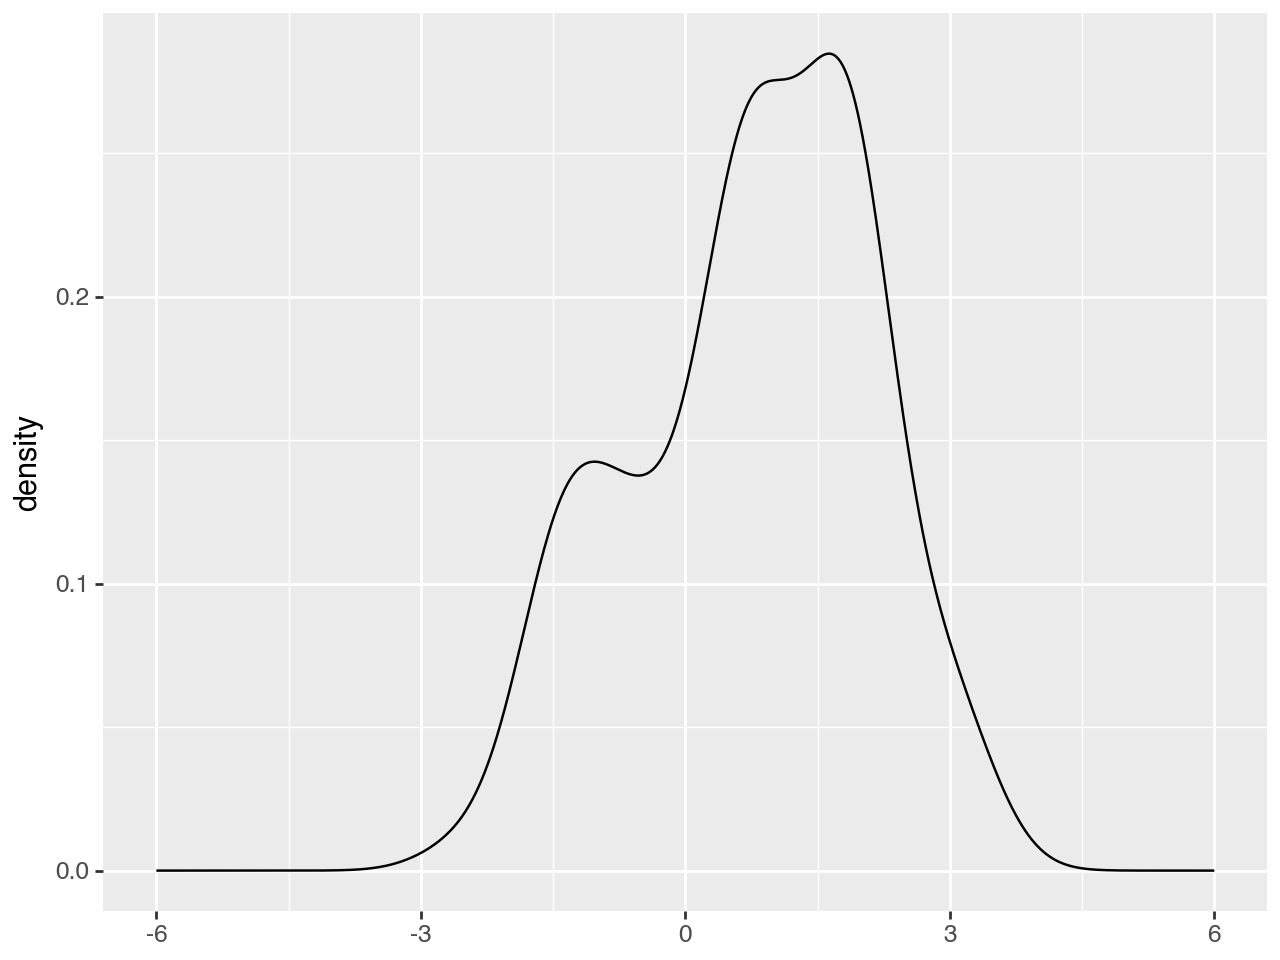

In [9]:
r_sample = model.response.value
(p9.ggplot() + p9.geom_density(p9.aes(r_sample)) + p9.xlim((-6.0, 6.0)))

In [10]:
results = model.run_mcmc(seed=2, warmup=200, posterior=50)

liesel.goose.builder - WARNING - No jitter functions provided for position keys 'trafo0_latent', 'trafo0_scale_square_transformed', 'scale_intercept', 'loc_intercept'. The initial values for these keys won't be jittered
liesel.goose.engine - INFO - Initializing kernels...
liesel.goose.engine - INFO - Done
liesel.goose.engine - INFO - Starting epoch: FAST_ADAPTATION, 50 transitions, 25 jitted together
100%|██████████████████████████████████████████| 2/2 [00:04<00:00,  2.33s/chunk]
liesel.goose.engine - WARNING - Errors per chain for kernel_00: 12, 9, 11, 10 / 50 transitions
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION, 25 transitions, 25 jitted together
100%|████████████████████████████████████████| 1/1 [00:00<00:00, 1017.05chunk/s]
liesel.goose.engine - WARNING - Errors per chain for kernel_00: 3, 8, 12, 14 / 25 transitions
liesel.goose.engine - INFO - Finished epoch
liesel.goose.engine - INFO - Starting epoch: SLOW_ADAPTATION

In [11]:
samples = results.get_posterior_samples()

In [12]:
jnp.asarray(model.trafo.value).ndim

1

/Users/johannesbrachem/Documents/git/liesel_ptm2/.venv/lib/python3.13/site-packages/arviz/stats/diagnostics.py:845: RuntimeWarning: invalid value encountered in scalar divide
/Users/johannesbrachem/Documents/git/liesel_ptm2/.venv/lib/python3.13/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide


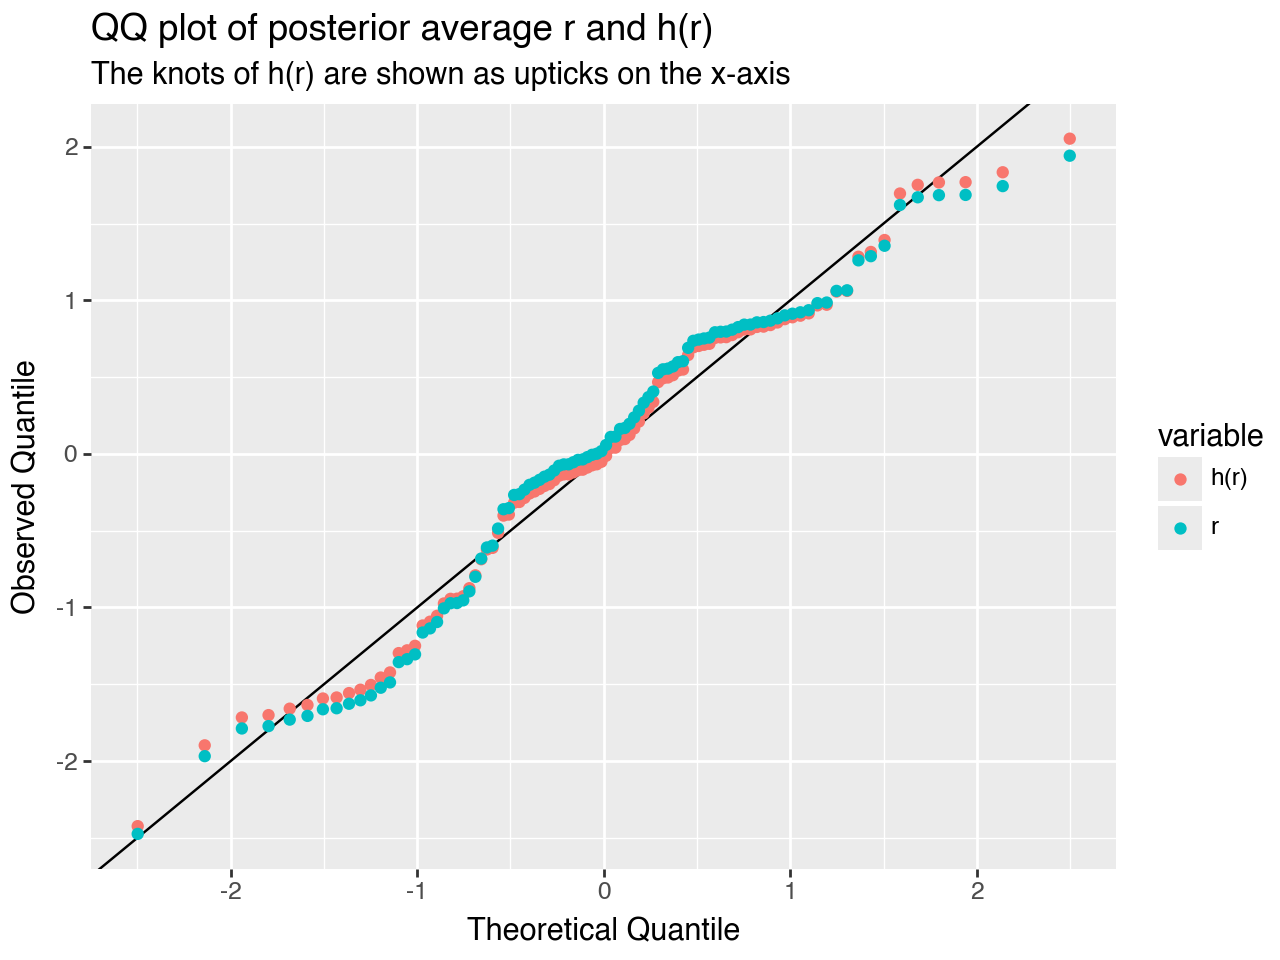

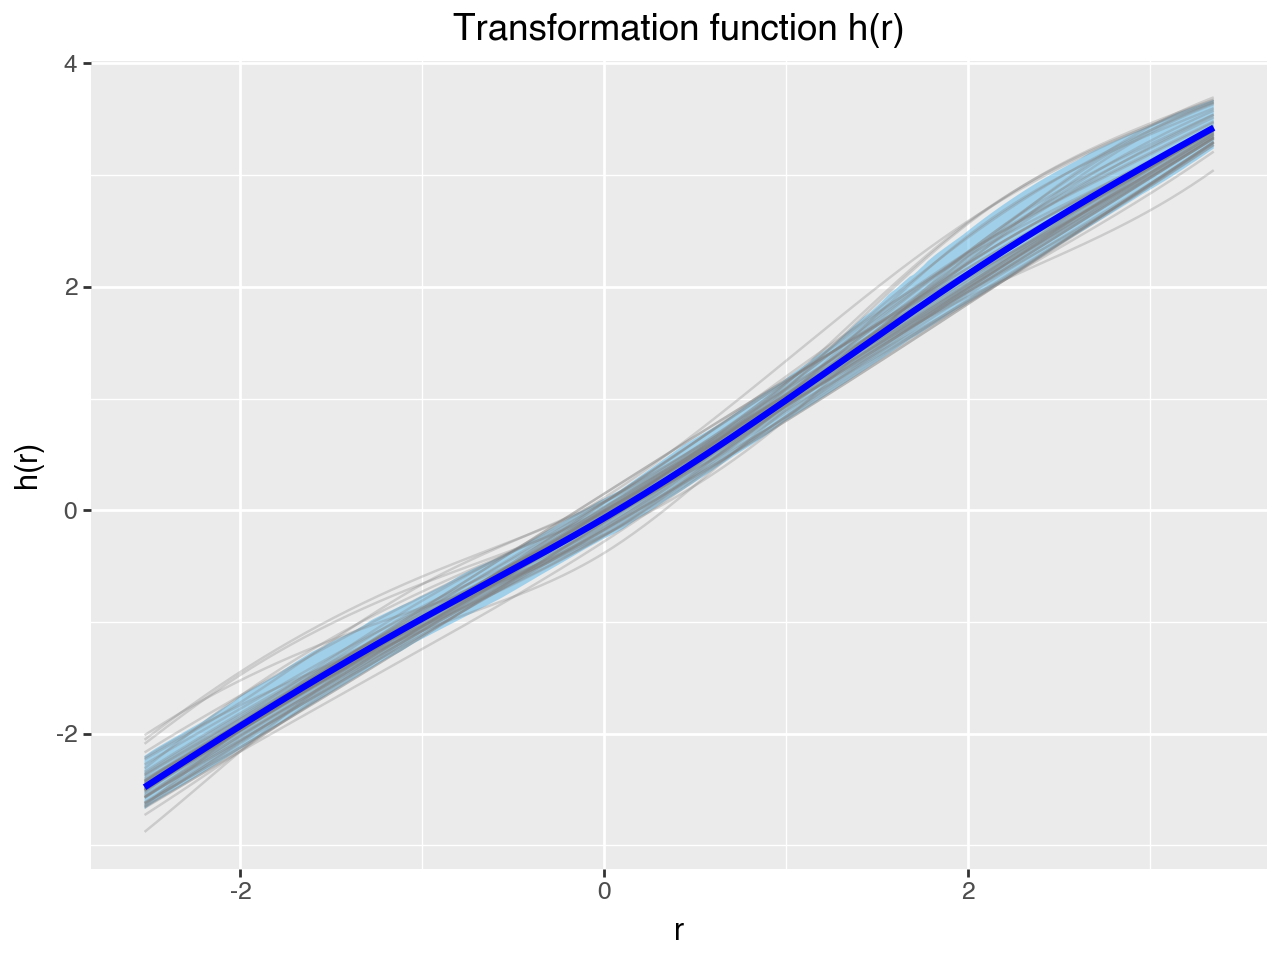

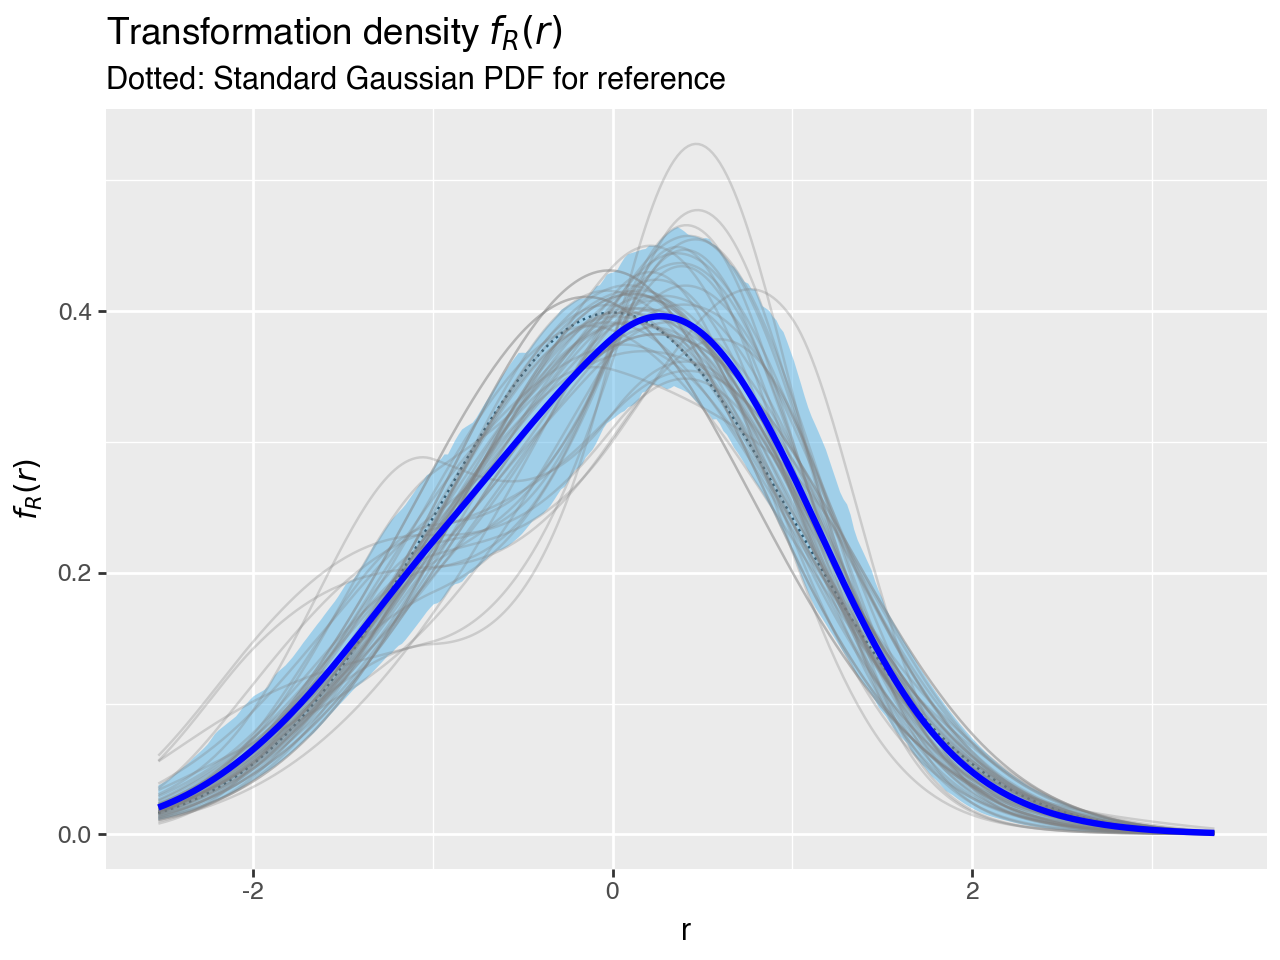

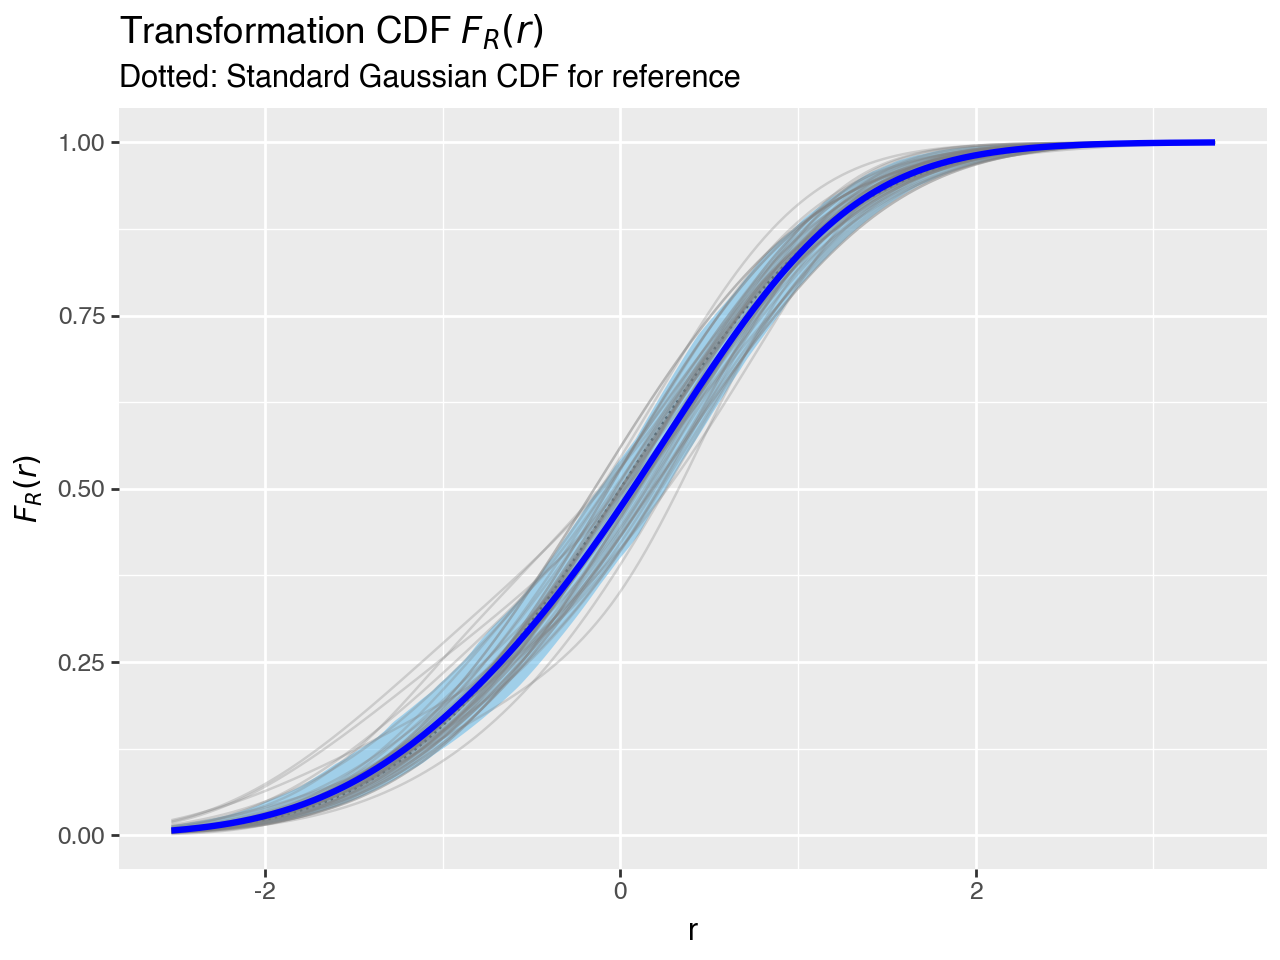

In [13]:
_ = model.plot(samples)

/Users/johannesbrachem/Documents/git/liesel_ptm2/.venv/lib/python3.13/site-packages/arviz/stats/diagnostics.py:845: RuntimeWarning: invalid value encountered in scalar divide
/Users/johannesbrachem/Documents/git/liesel_ptm2/.venv/lib/python3.13/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide


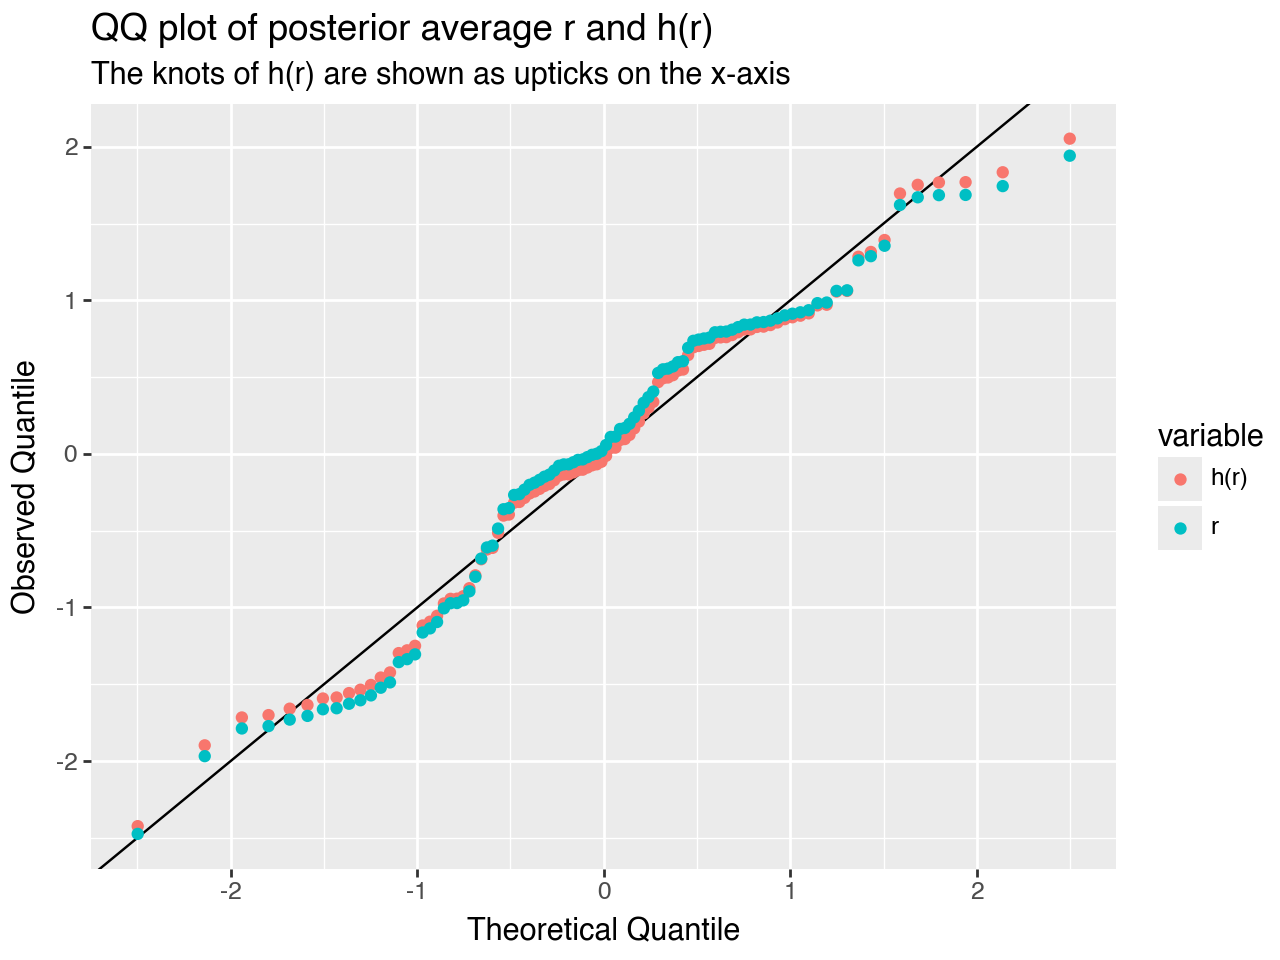

In [14]:
model.plot_qq(samples)

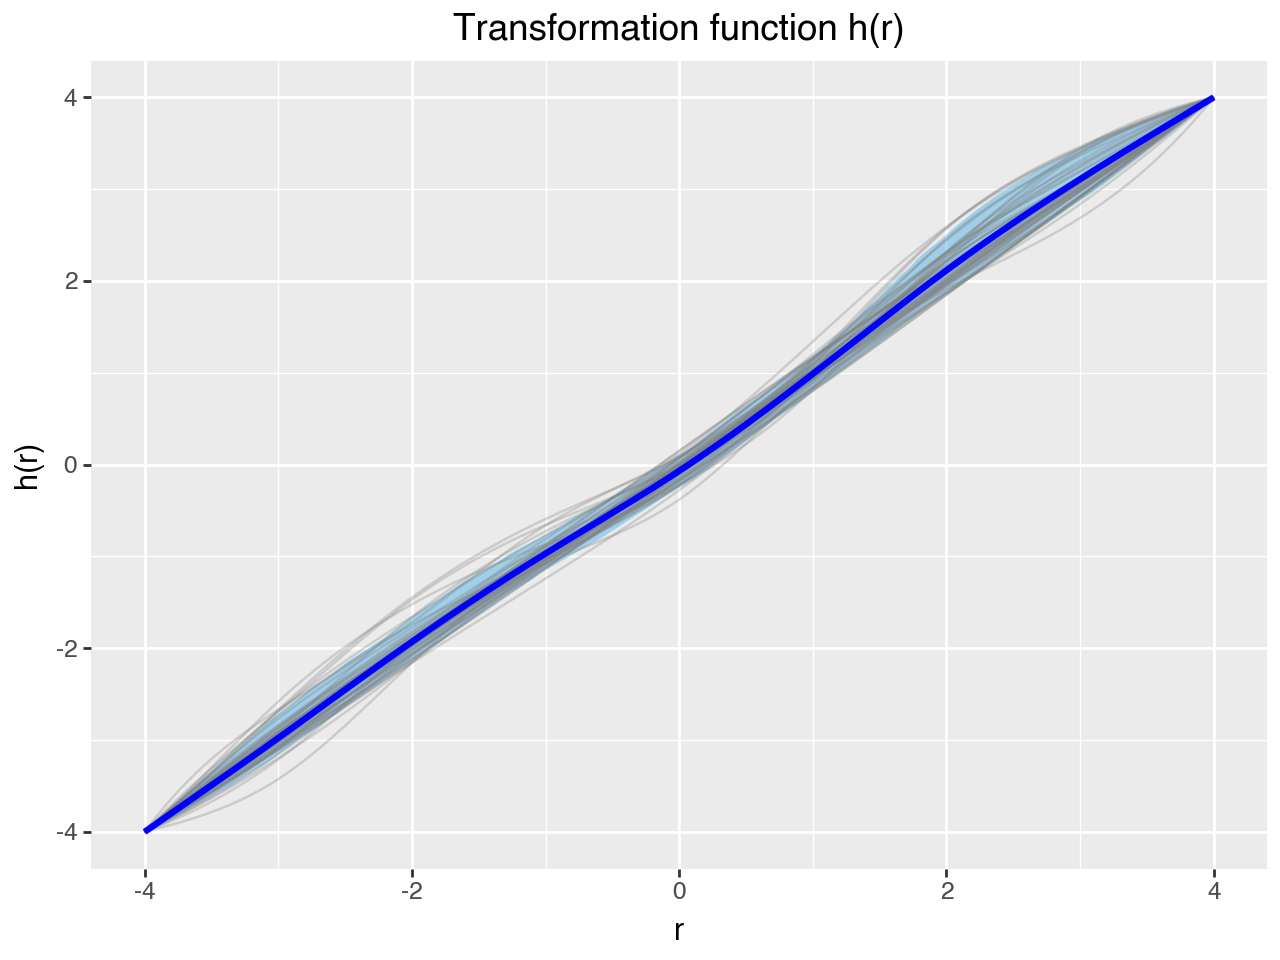

In [15]:
model.plot_trafo(samples, show_n_samples=50, grid=jnp.linspace(-4.0, 4.0, 300))

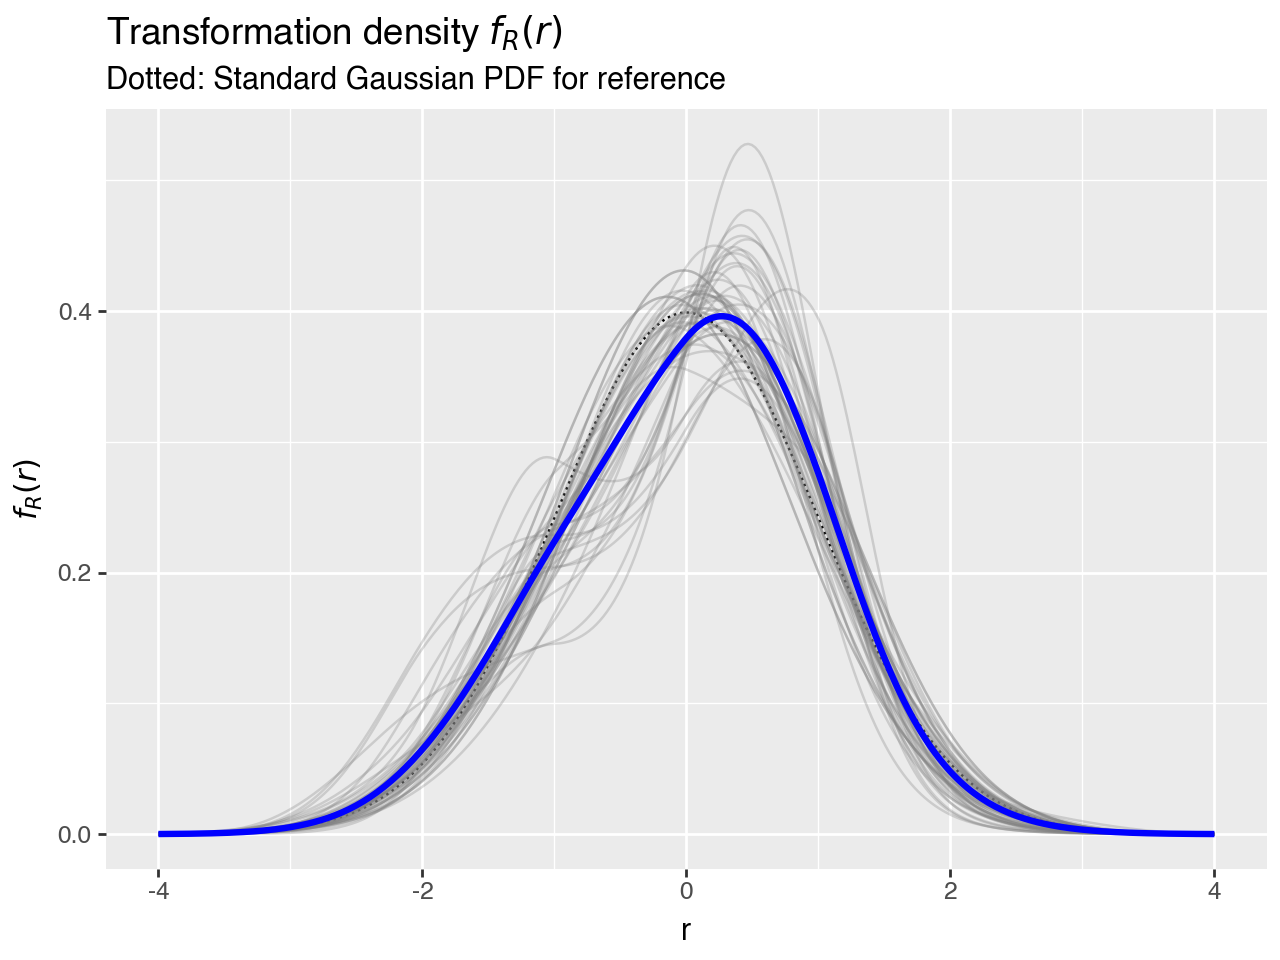

In [16]:
model.plot_r_density(
    samples, hdi_prob=None, ci_quantiles=None, grid=jnp.linspace(-4.0, 4.0, 300)
)

/Users/johannesbrachem/Documents/git/liesel_ptm2/.venv/lib/python3.13/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide


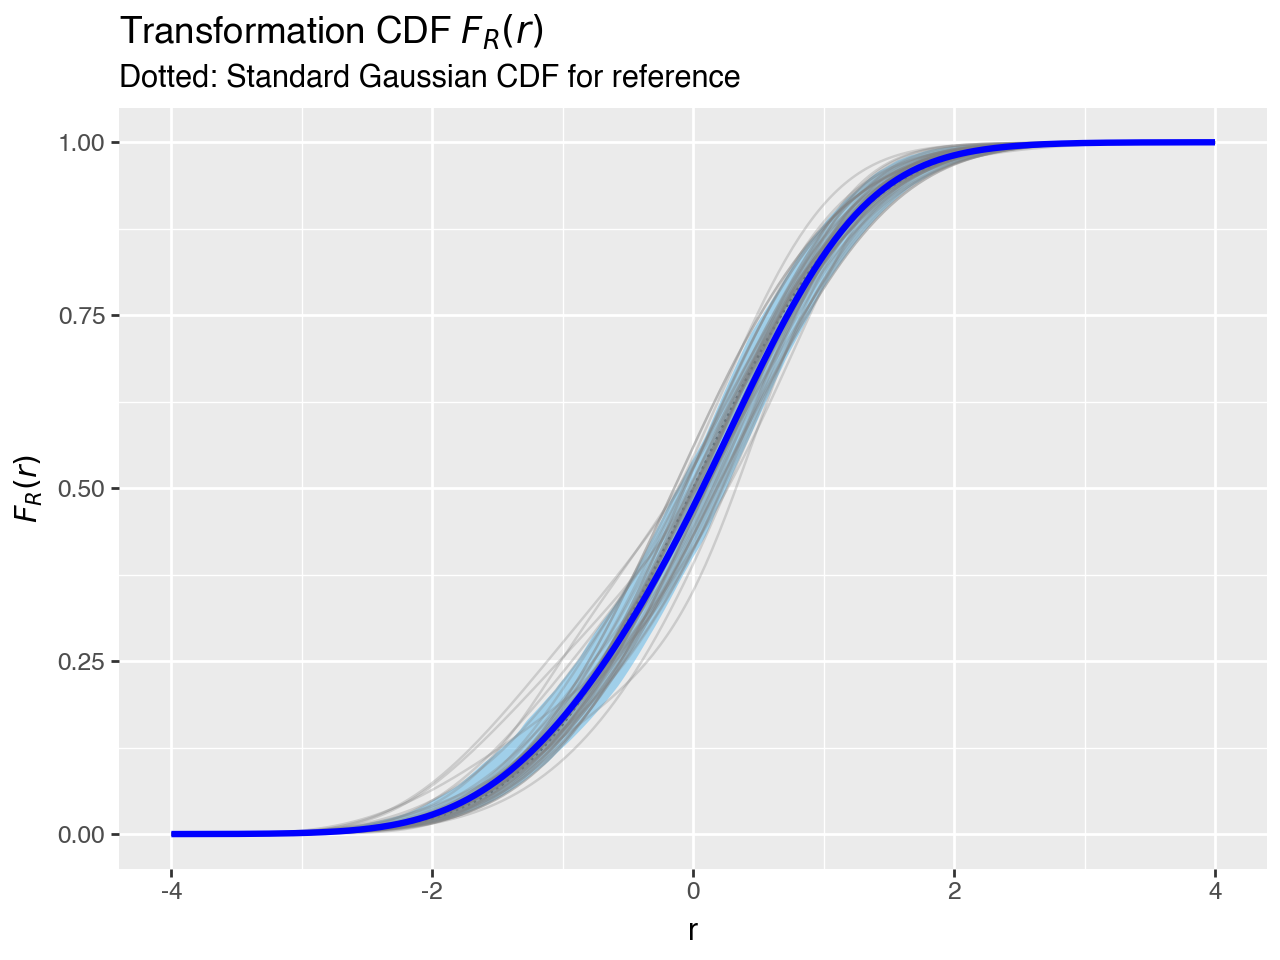

In [17]:
model.plot_r_cdf(samples, show_n_samples=50, grid=jnp.linspace(-4.0, 4.0, 300))

In [18]:
gs.Summary(results)

/Users/johannesbrachem/Documents/git/liesel_ptm2/.venv/lib/python3.13/site-packages/arviz/stats/diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide


Parameter summary:

                                          kernel      mean            sd  \
parameter                       index                                      
loc_intercept                   ()     kernel_02  0.764880  5.960464e-08   
scale_intercept                 ()     kernel_01  0.285308  2.980232e-08   
trafo0_latent                   (0,)   kernel_00  0.018259  4.772249e-02   
                                (1,)   kernel_00  0.036402  9.862963e-02   
                                (2,)   kernel_00  0.084632  1.452282e-01   
                                (3,)   kernel_00 -0.078389  1.369935e-01   
                                (4,)   kernel_00 -0.122688  1.759953e-01   
                                (5,)   kernel_00  0.071735  1.551400e-01   
                                (6,)   kernel_00  0.075393  1.478722e-01   
                                (7,)   kernel_00  0.004598  1.495009e-01   
                                (8,)   kernel_00 -0.030991  1.572666e-01   
trafo0_scale_square_transformed ()     kernel_00 -4.497964  1.781345e+00   

                                         q_0.05     q_0.5    q_0.95  \
parameter                       index                                 
loc_intercept                   ()     0.764880  0.764880  0.764880   
scale_intercept                 ()     0.285308  0.285308  0.285308   
trafo0_latent                   (0,)  -0.042581  0.010181  0.112030   
                                (1,)  -0.106801  0.022235  0.230174   
                                (2,)  -0.108495  0.053105  0.378819   
                                (3,)  -0.353179 -0.041245  0.089914   
                                (4,)  -0.424546 -0.077635  0.059302   
                                (5,)  -0.144585  0.030257  0.359442   
                                (6,)  -0.076803  0.030843  0.337661   
                                (7,)  -0.246557 -0.000666  0.275558   
                                (8,)  -0.323471 -0.014233  0.180752   
trafo0_scale_square_transformed ()    -7.666763 -4.171382 -1.886247   

                                       sample_size    ess_bulk    ess_tail  \
parameter                       index                                        
loc_intercept                   ()             200  200.000000  200.000000   
scale_intercept                 ()             200  200.000000  200.000000   
trafo0_latent                   (0,)           200  187.637805  104.450141   
                                (1,)           200   93.621399  122.916445   
                                (2,)           200  181.835122  134.462432   
                                (3,)           200   45.106802  125.624625   
                                (4,)           200   38.222598  112.972267   
                                (5,)           200  116.709913  132.078743   
                                (6,)           200  128.711730  147.767995   
                                (7,)           200  122.415634  107.271133   
                                (8,)           200  197.676552   99.513802   
trafo0_scale_square_transformed ()             200   10.478413   16.473108   

                                           rhat  
parameter                       index            
loc_intercept                   ()          NaN  
scale_intercept                 ()          NaN  
trafo0_latent                   (0,)   1.071177  
                                (1,)   1.020727  
                                (2,)   1.049656  
                                (3,)   1.068944  
                                (4,)   1.083232  
                                (5,)   1.086885  
                                (6,)   1.068601  
                                (7,)   1.153533  
                                (8,)   1.215839  
trafo0_scale_square_transformed ()     1.355142  

Error summary:

                                                    count relative
kernel    error_code error_msg            p

In [19]:
samples = results.get_posterior_samples()

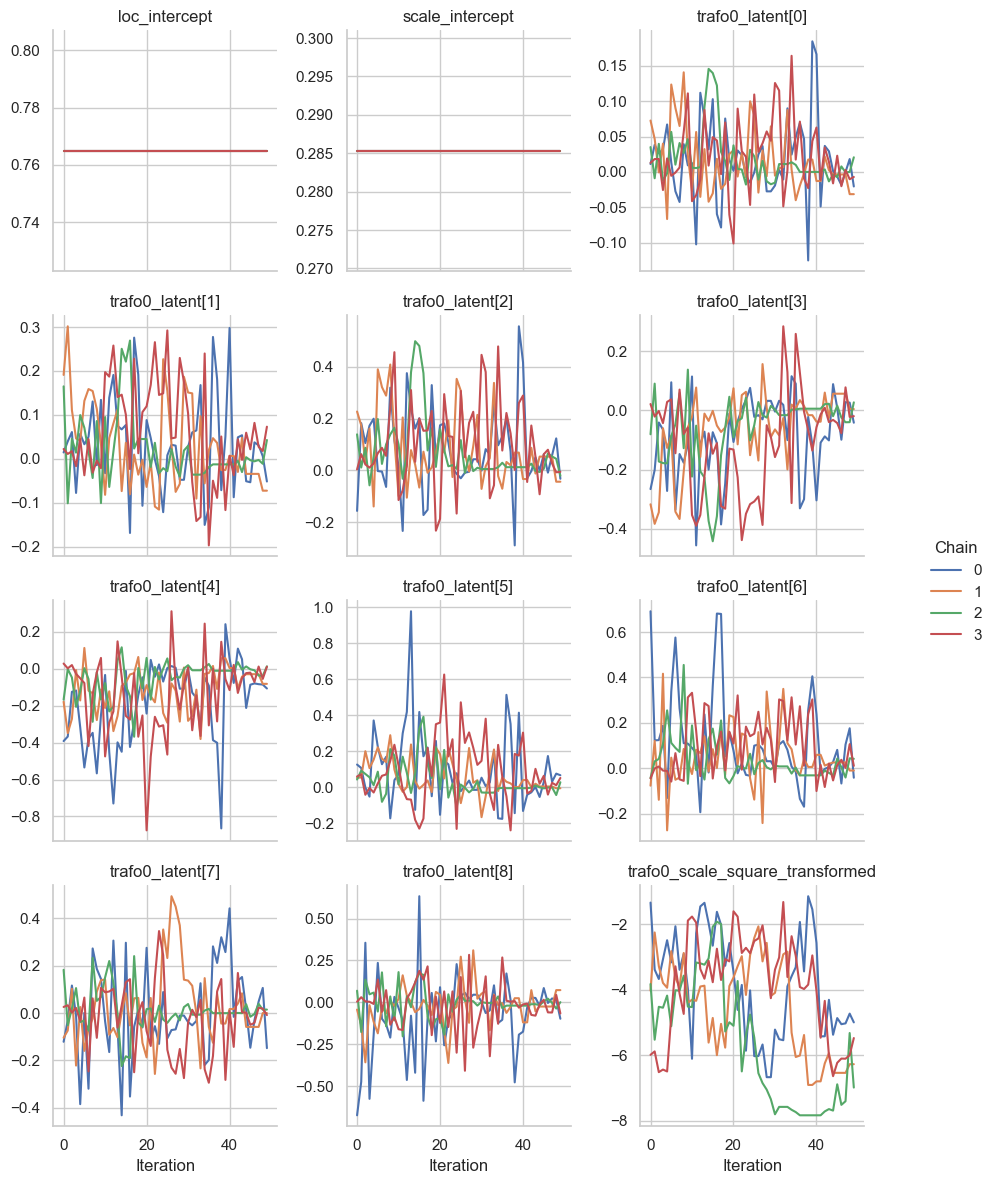

In [20]:
gs.plot_trace(jax.tree.map(jnp.squeeze, samples))

In [21]:
dist = model.init_dist(samples, loc=0.0, scale=1.0)
rgrid = jnp.linspace(-6.0, 6.0, 301)
probs = jnp.exp(dist.log_prob(rgrid))
z = dist.transformation_and_logdet(rgrid)[0]

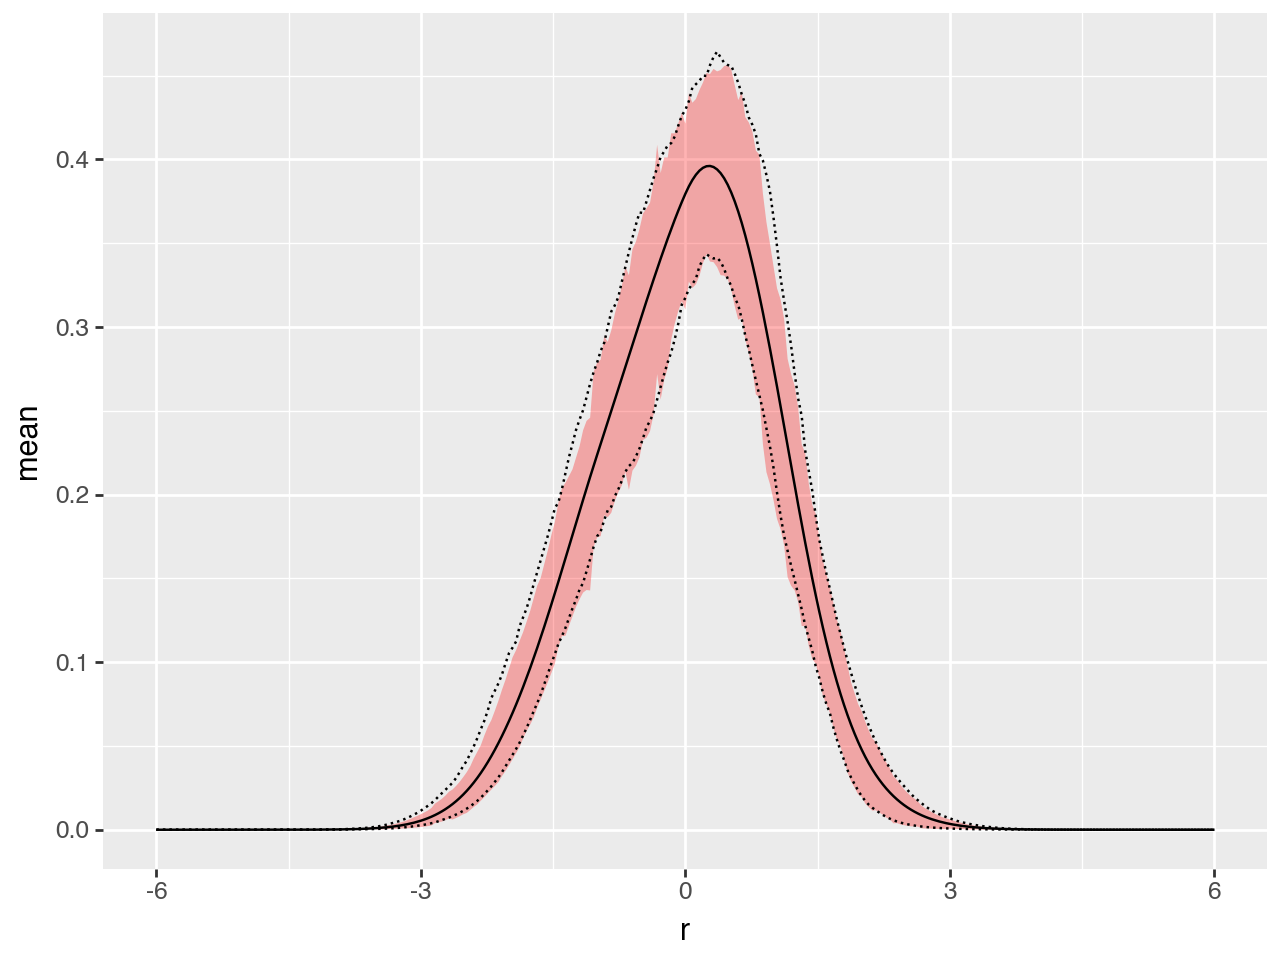

In [22]:
pdf_summary = gs.SamplesSummary({"pdf": probs}).to_dataframe().reset_index()
pdf_summary["r"] = rgrid

(
    p9.ggplot(pdf_summary)
    + p9.aes("r", "mean")
    + p9.geom_ribbon(
        p9.aes("r", ymin="hdi_low", ymax="hdi_high"), fill="red", alpha=0.3
    )
    + p9.geom_line()
    + p9.geom_line(p9.aes("r", y="q_0.05"), linetype="dotted")
    + p9.geom_line(p9.aes("r", y="q_0.95"), linetype="dotted")
)

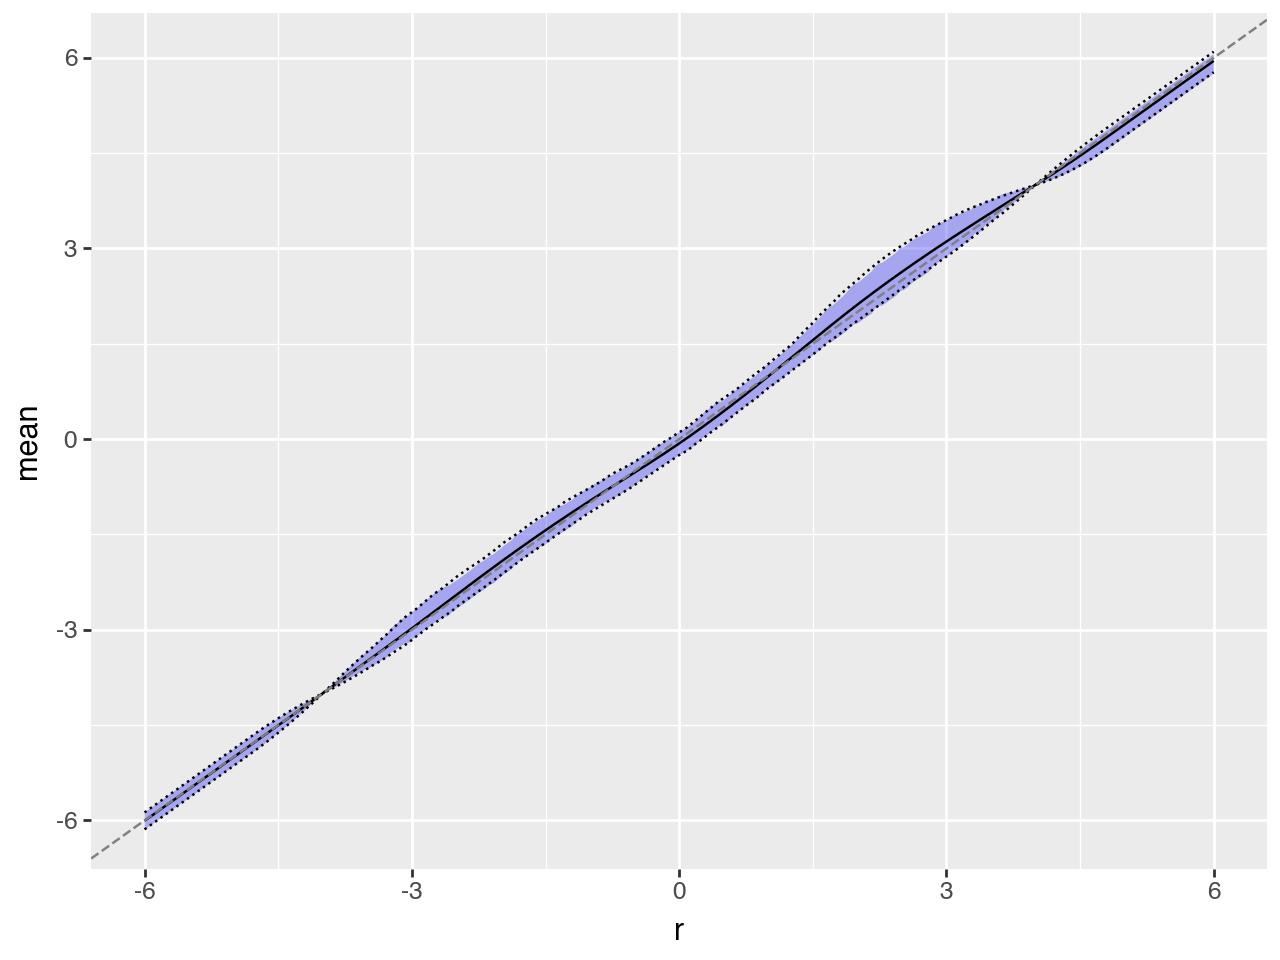

In [23]:
z_summary = gs.SamplesSummary({"z": z}).to_dataframe().reset_index()
z_summary["r"] = rgrid

(
    p9.ggplot(z_summary)
    + p9.aes("r", "mean")
    + p9.geom_ribbon(
        p9.aes("r", ymin="hdi_low", ymax="hdi_high"), fill="blue", alpha=0.3
    )
    + p9.geom_line()
    + p9.geom_line(p9.aes("r", y="q_0.05"), linetype="dotted")
    + p9.geom_line(p9.aes("r", y="q_0.95"), linetype="dotted")
    + p9.geom_abline(intercept=0.0, slope=1.0, linetype="dashed", color="grey")
)

In [24]:
pdf_samples = model.summarise_trafo_by_samples(
    jax.random.key(101), grid=rgrid, samples=samples
)
pdf_samples.head()

,z,cdf,pdf,index,obs,chain,sample,r
0,-6.076634,6.136562e-10,3.825099e-09,0,0,1,0,-6.00
1,-6.036634,7.868080e-10,4.873684e-09,1,1,1,0,-5.96
2,-5.996634,1.007246e-09,6.199791e-09,2,2,1,0,-5.92
3,-5.956635,1.287428e-09,7.874114e-09,3,3,1,0,-5.88
4,-5.916635,1.642978e-09,9.984617e-09,4,4,1,0,-5.84


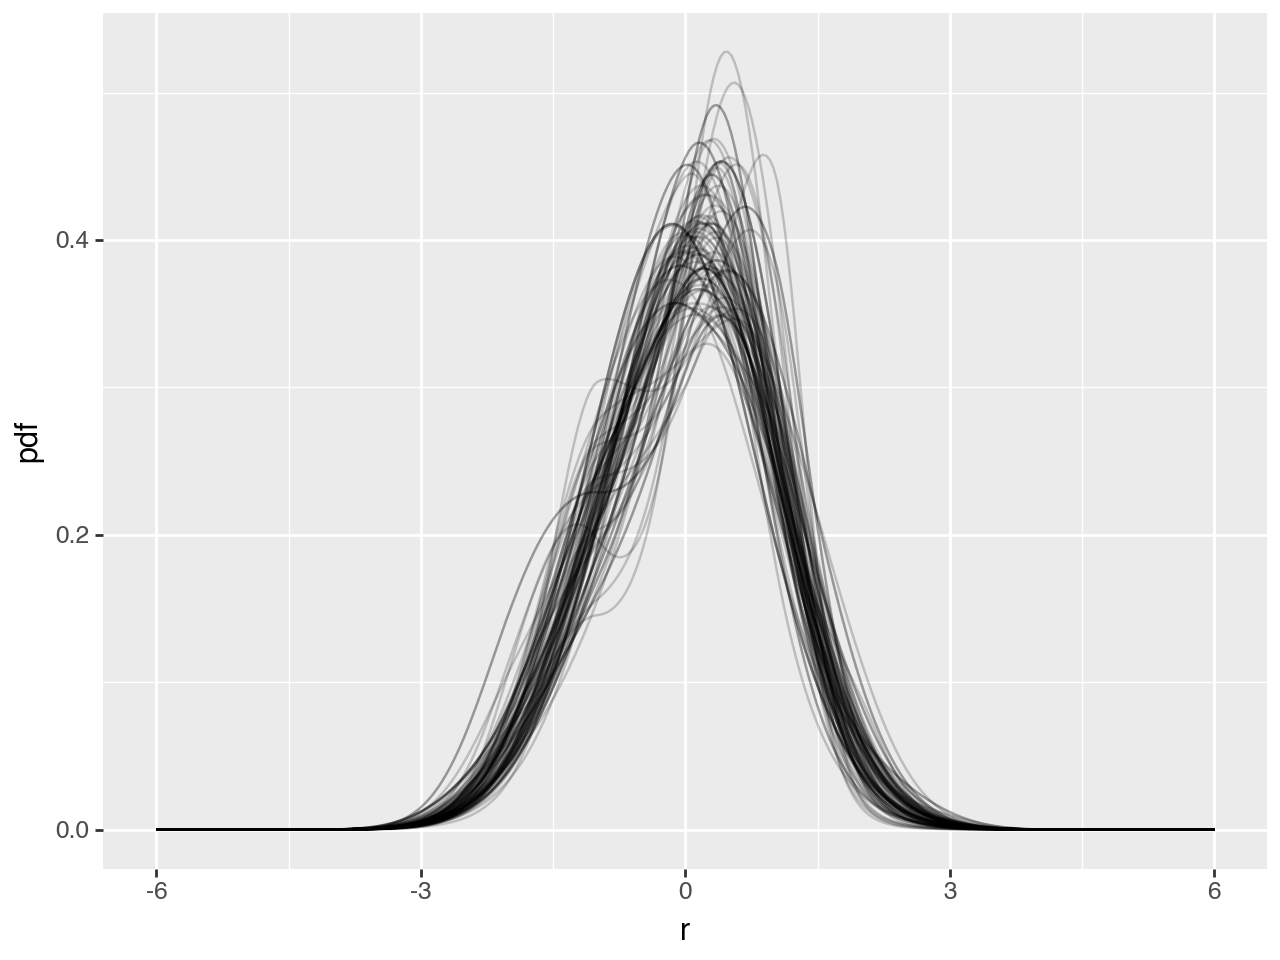

In [25]:
(
    p9.ggplot(pdf_samples)
    + p9.aes("r", "pdf")
    + p9.geom_line(p9.aes(group="sample"), alpha=0.2)
)

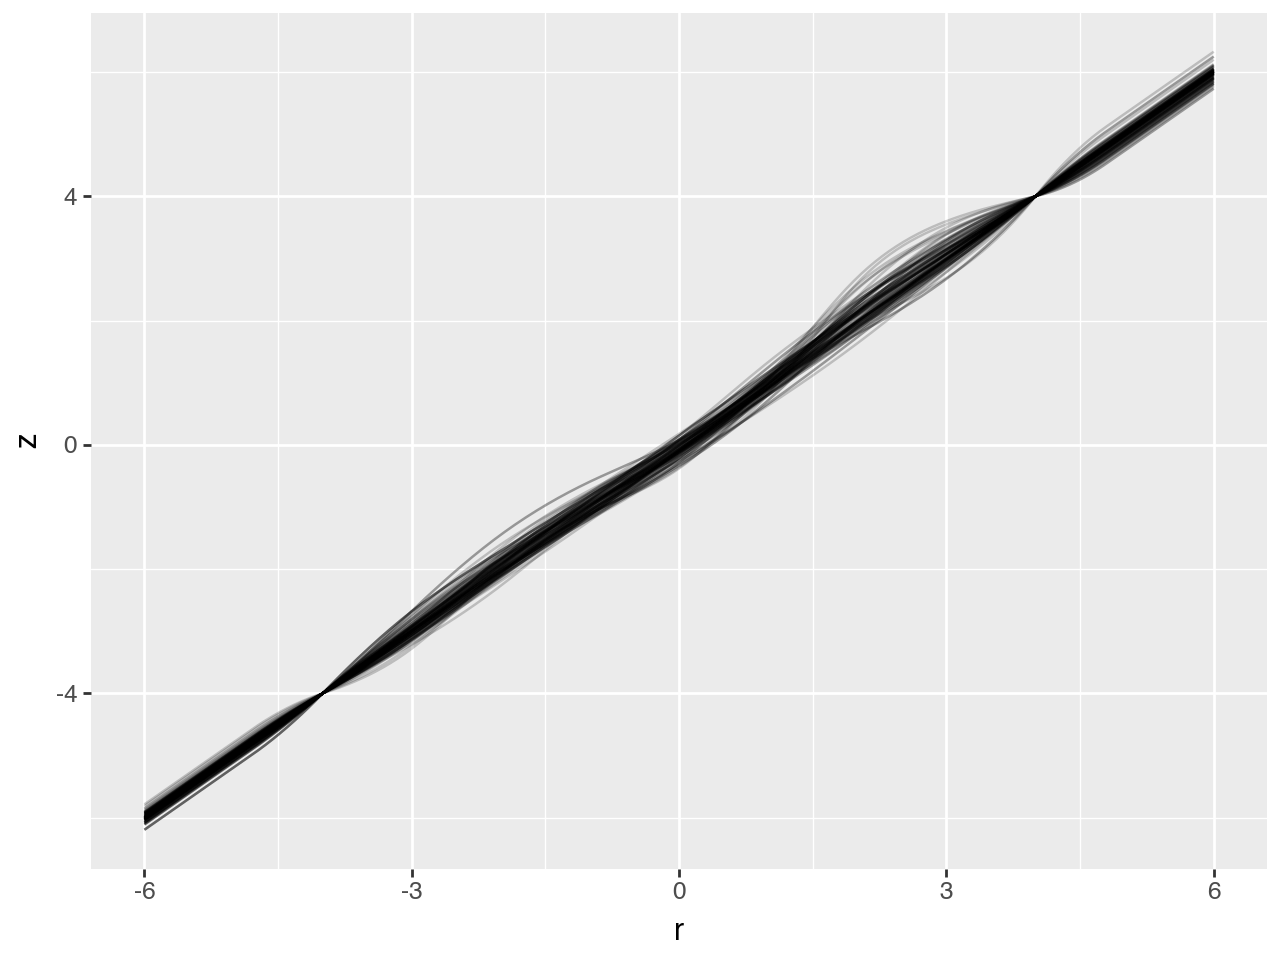

In [26]:
(
    p9.ggplot(pdf_samples)
    + p9.aes("r", "z")
    + p9.geom_line(p9.aes(group="sample"), alpha=0.2)
)

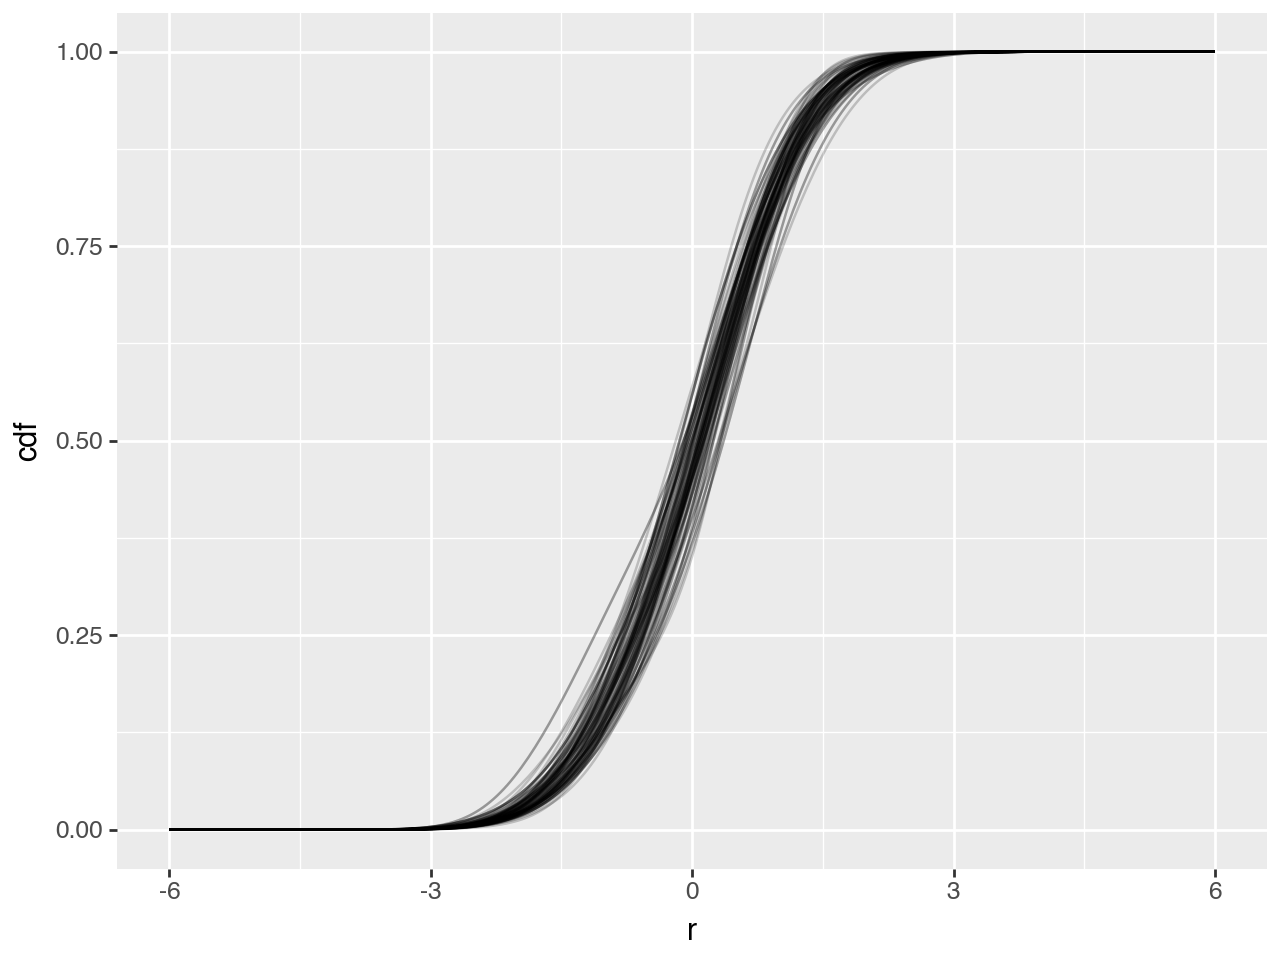

In [27]:
(
    p9.ggplot(pdf_samples)
    + p9.aes("r", "cdf")
    + p9.geom_line(p9.aes(group="sample"), alpha=0.2)
)

In [28]:
meval = ptm.EvaluatePTM(model, samples)
newdata = {"response": y}

In [29]:
meval.log_score(newdata)

Array(167.99954, dtype=float32)

In [30]:
meval.waic()

,waic_lppd,waic_elpd,waic_se,waic_p,waic_deviance,n_warning
0,-167.99954,-170.53006,5.669236,2.5305223,341.06012,0


In [31]:
meval.crps(jnp.array([0.2, 0.3]), newdata)

Array(0.13328817, dtype=float32)

In [32]:
meval.wasserstein1(jnp.linspace(0.01, 0.99, num=y.size), newdata).shape

(4, 50)

In [33]:
meval.wasserstein2(jnp.linspace(0.01, 0.99, num=y.size), newdata).shape

(4, 50)

In [34]:
meval.kld(jnp.linspace(0.01, 0.99, num=y.size), newdata)

Array(2.1799953, dtype=float32)